Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Loading dataset

In [ ]:
data=pd.read_csv("../input/sms-spam-collection-dataset/spam.csv",encoding="latin")
data.head()

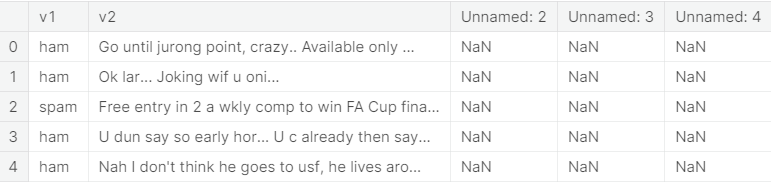

The dataset contains 5 columns of which 3 Unnamed columns are not important for us

In [ ]:
Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

Drop these three columns

In [ ]:
data=data.drop(columns=["Unnamed: 2","Unnamed: 3","Unnamed: 4"])

columns v1 & v2 does not make any sense so rename the columns into meaningful Category & Message names

In [ ]:
data=data.rename(
{
    "v1":"Category",
    "v2":"Message"
},
    axis=1
)

Display head of the new dataset

In [ ]:
data.head()

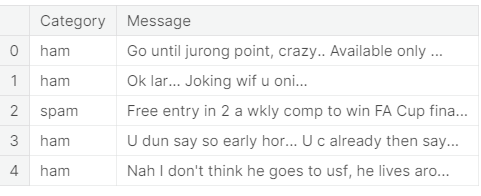

Check if the dataset contains any null values, luckily we got dataset without any null values

In [ ]:
data.isnull().sum()

Category    0

Message     0

dtype: *int64*

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 5572 entries, 0 to

Data columns (total 2 columns):

 $   Column    Non-Null Count  Dtype

---   ------     --------------   -----
 0    Category   5572  non-null    object

 1    Message    5572  non-null    object

dtypes: object(2)

memory usage: 87.2+ KB

Create new column called Message Length that would compute the message lengths

In [ ]:
data["Message Length"]=data["Message"].apply(len)

Visualize the Messages length using histogram

In [ ]:
fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

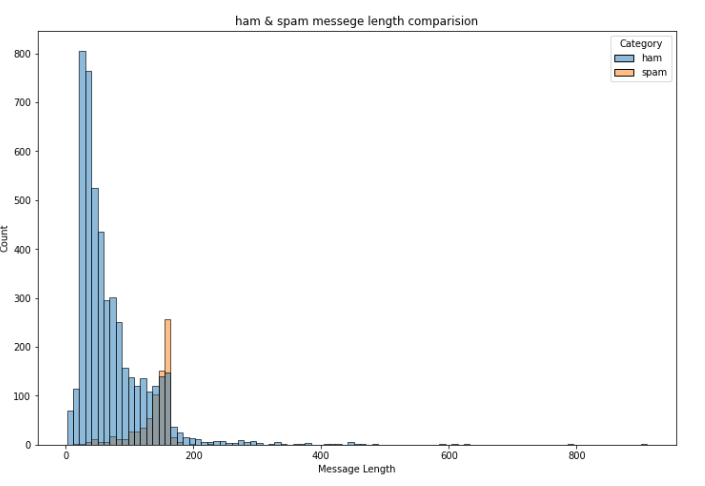

From the statistics of the two description we can see that the ham contains the longest message of 910 length. However more than 70% of the ham messages contains messages of length less than 90.

In [ ]:
ham_desc=data[data["Category"]=="ham"]["Message Length"].describe()
spam_desc=data[data["Category"]=="spam"]["Message Length"].describe()

print("Ham Messege Length Description:\n",ham_desc)
print("************************************")
print("Spam Message Length Description:\n",spam_desc)

Ham Messege Length Description:

 count    4825.000000

mean       71.023627

std        58.016023

min         2.000000

25%        33.000000

50%        52.000000

75%        92.000000

max       910.000000

Name: Message Length, dtype: float64

************************************

Spam Message Length Description:

 count    747.000000

mean     138.866131

std       29.183082

min       13.000000

25%      132.500000

50%      149.000000

75%      157.000000

max      224.000000

Name: Message Length, dtype: float64

In [ ]:
data.describe(include="all")

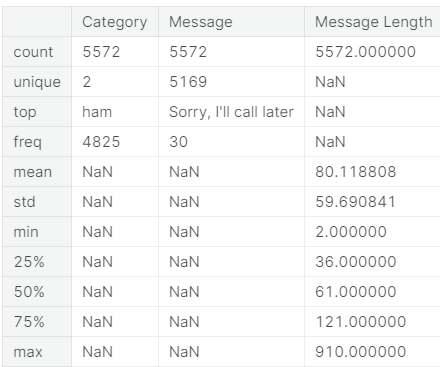

The two unique values are ham & spam and ham contains 4825 & spam with 747 entries which is a vast difference

In [ ]:
data["Category"].value_counts()

ham     4825

spam     747

Name: Category, dtype: int64

Visualizing the Category using countplot shows our spam messages are relatively less compared to the ham messages in the dataset

In [ ]:
sns.countplot(
    data=data,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

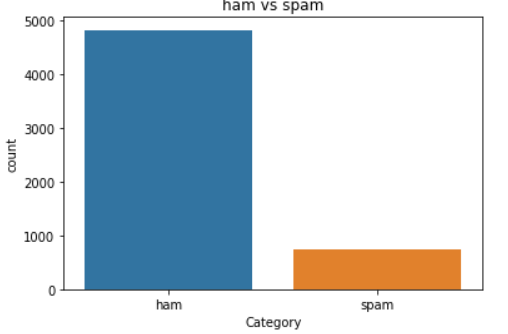

Ham contains 86.6% while spam constitute only 13.4% of the total dataset, and thus we can conclude that the data is imbalanced

In [ ]:
ham_count=data["Category"].value_counts()[0]
spam_count=data["Category"].value_counts()[1]

total_count=data.shape[0]

print("Ham contains:{:.2f}% of total data.".format(ham_count/total_count*100))
print("Spam contains:{:.2f}% of total data.".format(spam_count/total_count*100))

Ham contains:86.59% of total data.

Spam contains:13.41% of total data.

In [ ]:
#compute the length of majority & minority class
minority_len=len(data[data["Category"]=="spam"])
majority_len=len(data[data["Category"]=="ham"])

#store the indices of majority and minority class
minority_indices=data[data["Category"]=="spam"].index
majority_indices=data[data["Category"]=="ham"].index

#generate new majority indices from the total majority_indices
#with size equal to minority class length so we obtain equivalent number of indices length
random_majority_indices=np.random.choice(
    majority_indices,
    size=minority_len,
    replace=False
)

#concatenate the two indices to obtain indices of new dataframe
undersampled_indices=np.concatenate([minority_indices,random_majority_indices])

#create df using new indices
df=data.loc[undersampled_indices]
#shuffle the sample
df=df.sample(frac=1)

#reset the index as its all mixed
df=df.reset_index()

#drop the older index
df=df.drop(
    columns=["index"],
)

The resulting dataframes have 1494 rows and 4 columns

In [ ]:
df.shape

(1494, 3)

Now we can see that the category cotains 747 entries for ham and spam and now we have a balanced dataset.

In [ ]:
df["Category"].value_counts()

ham     747

spam    747

Name: Category, dtype: int64

Both ham and spam message bars are now equal and hence obtained a balanced dataset.

In [ ]:
sns.countplot(
    data=df,
    x="Category"
)
plt.title("ham vs spam")
plt.show()

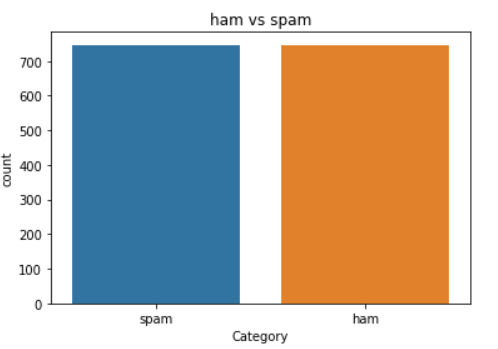

Display the head of new df

In [ ]:
df.head()

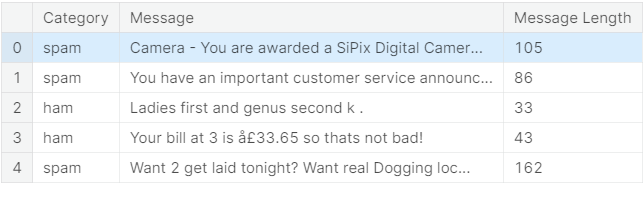

Created new column Label and encode ham as 0 and spam as 1

In [ ]:
df["Label"]=df["Category"].map(
    {
        "ham":0,
        "spam":1
    }
)

display head to see the new column

In [ ]:
df.head()

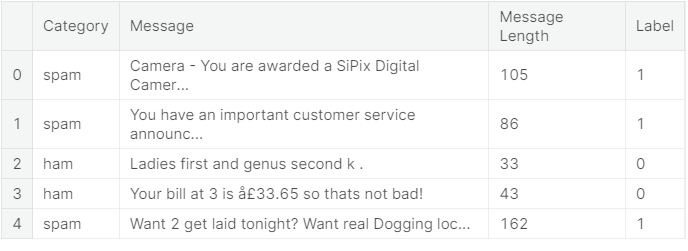

Import libraries to perform word tokenization

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer=PorterStemmer()

Perform word tokenization using the below block of code

In [ ]:
#declare empty list to store tokenized message
corpus=[]

#iterate through the df["Message"]
for message in df["Message"]:

    #replace every special characters, numbers etc.. with whitespace of message
    #It will help retain only letter/alphabets
    message=re.sub("[^a-zA-Z]"," ",message)

    #convert every letters to its lowercase
    message=message.lower()

    #split the word into individual word list
    message=message.split()

    #perform stemming using PorterStemmer for all non-english-stopwords
    message=[stemmer.stem(words)
            for words in message
             if words not in set(stopwords.words("english"))
             ]
    #join the word lists with the whitespace
    message=" ".join(message)

    #append the message in corpus list
    corpus.append(message)

Perform one_hot on the corpus

I have initialized the vocabulary size to 10,000.

oneHot_doc will contain the list of indices of words in the corpus whose indices will range in bw 0-10,000.

In [ ]:
from tensorflow.keras.preprocessing.text import one_hot
vocab_size=10000

oneHot_doc=[one_hot(words,n=vocab_size)
           for words in corpus
           ]

After one_hot we will then perform word embedding

In [ ]:
df["Message Length"].describe()

count    1494.000000

mean      105.854752

std        58.094718

min         2.000000

25%        50.000000

50%       120.000000

75%       153.000000

max       910.000000

Name: Message Length, dtype: float64

visualizing the Messages length using kdeplot

In [ ]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=df["Message Length"],
    hue=df["Category"]
)
plt.title("ham & spam messege length comparision")
plt.show()

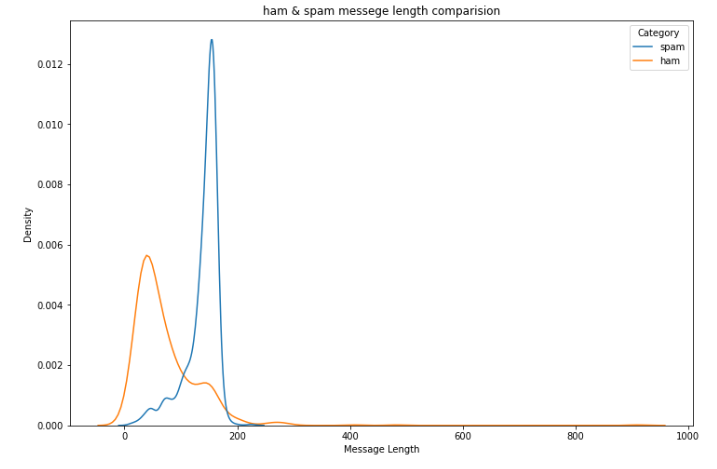

We will use pad_sequences from keras to perform word embedding.

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentence_len=200
embedded_doc=pad_sequences(
    oneHot_doc,
    maxlen=sentence_len,
    padding="pre"
)

target using Label column from df

In [ ]:
extract_features=pd.DataFrame(
    data=embedded_doc
)
target=df["Label"]

I have concatenated two dataframes to get the final dataframe



In [ ]:
df_final=pd.concat([extract_features,target],axis=1)

In [ ]:
df_final.head()

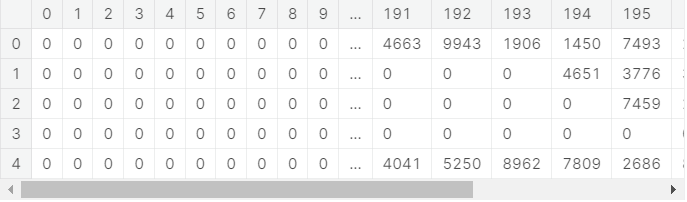

Split the dataframe into dependent(y) & independent(X) variables

In [ ]:
X=df_final.drop("Label",axis=1)
y=df_final["Label"]

In [ ]:
from sklearn.model_selection import train_test_split

Trainval dataset will contain the dataset for training and validation sets, which will constitute 85% of the data and rest as test data(15%).

X_trainval,X_test,y_trainval,y_test=train_test_split(
    X,
    y,
    random_state=42,
    test_size=0.15
)

We have splitted 85% dataset into training and validataion so lets futher split our trainval data into training(85%) and validation(15%) dataset.

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(
    X_trainval,
    y_trainval,
    random_state=42,
    test_size=0.15
)

import libraries to create model

In [ ]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential

Initialize the Sequential model

In [ ]:
model=Sequential()

In [ ]:
feature_num=100
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=feature_num,
        input_length=sentence_len
    )
)
model.add(
    LSTM(
    units=128
    )
)

model.add(
    Dense(
        units=1,
        activation="sigmoid"
    )
)

Lets compile the model built above.

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(
    learning_rate=0.001
    ),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

Once the model is complied we will fit the model using train and validation dataset.

In [ ]:
model.fit(
    X_train,
    y_train,
    validation_data=(
        X_val,
        y_val
    ),
    epochs=10
)

Epoch 1/10
34/34 [==============================] - 5s 44ms/step - loss: 0.6029 - accuracy: 0.6803 - val_loss: 0.3381 - val_accuracy: 0.8796

Epoch 2/10
34/34 [==============================] - 1s 22ms/step - loss: 0.2607 - accuracy: 0.9302 - val_loss: 0.1262 - val_accuracy: 0.9424

Epoch 3/10
34/34 [==============================] - 1s 22ms/step - loss: 0.0825 - accuracy: 0.9738 - val_loss: 0.0667 - val_accuracy: 0.9843

The prediction will be stored in array of boolean where prediction value greater than 0.5 will be assigned True(Spam) else lesser than 0.5 will be False(Ham)

In [ ]:
y_pred=model.predict(X_test)
y_pred=(y_pred>0.5)

Lets import metrics to evaluate our model

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix

The model predicts pretty well on the test data as evident from the accuracy score.

In [ ]:
score=accuracy_score(y_test,y_pred)
print("Test Score:{:.2f}%".format(score*100))

Test Score:95.11%

Lets visualize our confusion_matrix using heatmap

In [ ]:
cm=confusion_matrix(y_test,y_pred)
fig=plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
)
plt.title("Confusion Matrix")
cm

array([[ 91,   5],
       [  6, 123]])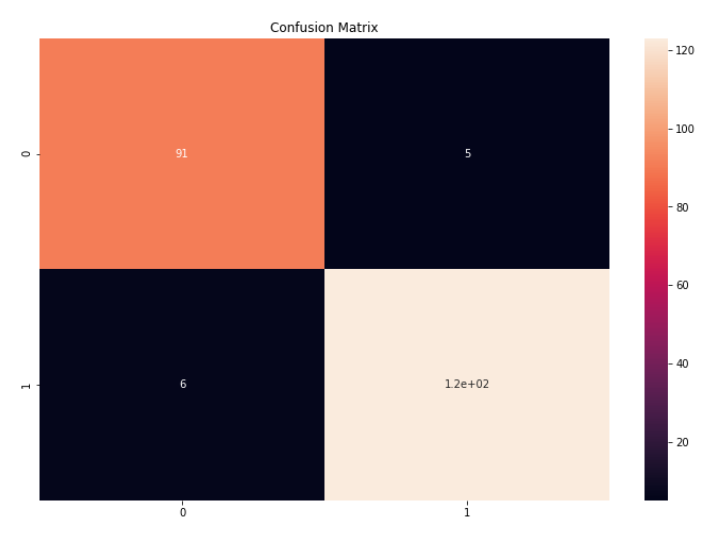

In [ ]:
#The function take model and message as parameter
def classify_message(model,message):

    #We will treat message as a paragraphs containing multiple sentences(lines)
    #we will extract individual lines
    for sentences in message:
        sentences=nltk.sent_tokenize(message)

        #Iterate over individual sentences
        for sentence in sentences:
            #replace all special characters
            words=re.sub("[^a-zA-Z]"," ",sentence)

            #perform word tokenization of all non-english-stopwords
            if words not in set(stopwords.words('english')):
                word=nltk.word_tokenize(words)
                word=" ".join(word)

    #perform one_hot on tokenized word
    oneHot=[one_hot(word,n=vocab_size)]
    #create an embedded documnet using pad_sequences
    #this can be fed to our model
    text=pad_sequences(oneHot,maxlen=sentence_len,padding="pre")

    #predict the text using model
    predict=model.predict(text)

    #if predict value is greater than 0.5 its a spam
    if predict>0.5:
        print("It is a spam")
    #else the message is not a spam
    else:
        print("It is not a spam")

In [ ]:
message1="I am having a bad day and I would like to have a break today"
message2="This is to inform you had won a lottery and the subscription will end in a week so call us."

The model predicts message1 as not a spam message

In [ ]:
classify_message(model,message1)

It is not a spam

The model predicts message2 as spam message

In [ ]:
classify_message(model,message2)

It is a spam